Research question 2: Do decision trees produce more intuitive explanations than LIME?

In [12]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 41.3 MB/s eta 0:00:00a 0:00:01


  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.transform import resize

blackbox_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

def preprocess_images(img_array):
    img_array = np.array([tf.image.resize(img_to_array(img), (224, 224)) for img in img_array])
    return preprocess_input(img_array)

def black_box_classify(img_array,convert_to_nr=True):
    preprocessed_imgs = preprocess_images(img_array)
    predictions = blackbox_model.predict(preprocessed_imgs)
    prediction_labels = decode_predictions(predictions, top = 1)
    labels_as_str = [row[0][1] for row in prediction_labels]
    if convert_to_nr:
        label_as_nr = label_encoder.transform(labels_as_str)
        return [[l]for l in label_as_nr]
    return [[l]for l in labels_as_str]

def black_box_lime(temp):
    resized_temp = resize(temp, (224, 224), mode='reflect', preserve_range=True).astype(np.uint8)
    resized_temp = np.expand_dims(resized_temp, axis=0)
    predictions = blackbox_model.predict(resized_temp)
    prediction_labels = decode_predictions(predictions, top = 1)
    labels_as_str = [row[0][1] for row in prediction_labels]
    label_as_nr = label_encoder.transform(labels_as_str)
    return [[l]for l in label_as_nr]

In [102]:
import numpy as np
import pickle
import hashlib
import pandas as pd

np.random.seed(42)

base_path = "/Users/karlgustav/Documents/GitHub/study/master-thesis/server/src/research/"
# base_path = "/Users/karl-gustav.kallasmaa/Documents/Projects/master-thesis/server/src/"
all_labels_path = f"{base_path}all_classes.txt"
all_concepts_path = f"{base_path}all_concepts.txt"
masks_path = f"{base_path}data/masks.pkl"
img_path = f"{base_path}data/resized_imgs.pkl"
labels_path = f"{base_path}data/classes.pkl"
ade_path = f"{base_path}data/objectInfo150.csv"

ade_classes = pd.read_csv(ade_path)

images = []
masks = []
unique_labels = []
with open(masks_path, 'rb') as f:
    masks = pickle.load(f)
with open(img_path, 'rb') as f:
    images = pickle.load(f)
with open(all_labels_path) as f:
    lines = f.read().splitlines()
    lines = [l.replace(' ', '_') for l in lines]
    unique_labels = np.array(list(set(lines)))

labels = black_box_classify(images,False)
labels = [l[0] for l in labels]

all_concept_values = ade_classes['Name'].tolist()
UNIQUE_CONCEPT_VALUES = sorted(list(set(all_concept_values)))
NR_OF_UNIQUE_CONCEPTS = len(UNIQUE_CONCEPT_VALUES)


image_hex_index_map = {hashlib.sha1(np.array(img).view(np.uint8)).hexdigest(): i for i,img in enumerate(images)}

index_img_map = {i:img for i,img in enumerate(images)}
index_label_map = {i:label for i,label in enumerate(labels)}
index_mask_map = {i:mask for i,mask in enumerate(masks)}
index_ade_map = {i:ade for i,ade in enumerate(ade_classes)}

test_image_count = 10

random_indexes = np.random.choice(list(index_img_map.keys()), test_image_count, replace=False)

random_images = [index_img_map[index] for index in random_indexes]
random_labels = np.array([index_label_map[index] for index in random_indexes])
random_masks = [index_mask_map[index] for index in random_indexes]

print("Total number of images "+str(len(images)))
print("Number of images used "+str(len(random_images)))

50/50 [==============================] - 35s 693ms/step
Total number of images 1592
Number of images used 10


In [5]:
from typing import List
from sklearn import preprocessing

def encode_categorical_values(values: List[str]):
    unique_values = sorted(list(set(values)))
    le = preprocessing.LabelEncoder()
    le.fit(unique_values)
    return le

label_encoder = encode_categorical_values(unique_labels)

Explain using lime

In [9]:
from lime import lime_image

def explain_with_lime(images):
    explainer = lime_image.LimeImageExplainer()
    explanations = []
    for i,image in enumerate(images):
        lime_img_exp = explainer.explain_instance(np.array(image),
                                                 classifier_fn=black_box_classify,
                                                 top_labels=3,
                                                 batch_size=100,
                                                 num_samples=150,
                                                 hide_color=None)
        temp, mask = lime_img_exp.get_image_and_mask(lime_img_exp.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
        prediction_on_temp = black_box_lime(temp)

        result = {
            "image": image,
            "explanation": temp,
            "mask": mask,
            "prediction": prediction_on_temp[0][0],
            "label": random_labels[i]
        }
        explanations.append(result)
    return explanations

Explain using the framework

In [75]:
from operator import itemgetter
from typing import Dict, List

def get_segments(img, mask, threshold=0.05):
    segs = np.unique(mask)
    segments = []
    total = mask.shape[0] * mask.shape[1]
    segments_classes = []
    for seg in segs:
        idxs = mask == seg
        sz = np.sum(idxs)
        if sz < threshold * total:
            continue
        segment = img * idxs[..., None]
        w, h, _ = np.nonzero(segment)
        segment = segment[np.min(w):np.max(w), np.min(h):np.max(h), :]
        segments.append(segment)
        segments_classes.append(ade_classes['Name'].loc[ade_classes['Idx'] == seg].iloc[0])
    return segments, segments_classes

def sort_dictionary(source: Dict[any, any], by_value=True, reverse=True) -> List[any]:
    if by_value:
        return sorted(source.items(), key=itemgetter(1), reverse=reverse)
    return sorted(source.items(), key=itemgetter(0), reverse=reverse)

In [76]:
from typing import Dict, List
from mpire import WorkerPool
from functools import reduce

class MostPopularConcepts:
    BATCH_SIZE = 10
    MAX_WORKER_COUNT = 8

    def __init__(self,l_labels,i_images,m_maks):
        all_labels = np.array(l_labels)
        chunk_size = max(1, int(all_labels.size / self.BATCH_SIZE))
        self.labels_in_chunks = np.array_split(all_labels, chunk_size)
        self.nr_of_jobs = min(self.MAX_WORKER_COUNT, len(self.labels_in_chunks))

        self.label_images_map = {}
        self.label_masks_map = {}

        self.image_most_popular_concepts = self.static_most_popular_concepts(l_labels,i_images,m_maks)

    def static_most_popular_concepts(self,l_labels,i_images,m_maks) -> Dict[str, List[any]]:
        for label, image, mask in zip(l_labels,i_images,m_maks):
            current_images = self.label_images_map.get(label, [])
            current_maks = self.label_masks_map.get(label, [])

            current_images.append(image)
            current_maks.append(mask)

            self.label_images_map[label] = current_images
            self.label_masks_map[label] = current_maks

        with WorkerPool(n_jobs=self.nr_of_jobs) as pool:
            return reduce(lambda a, b: {**a, **b},
                          pool.map(self.__extract_most_popular_concepts, self.labels_in_chunks))

    def __extract_most_popular_concepts(self, l_labels: List[str]) -> Dict[str, List[any]]:
        partial_results = {}
        for label in  l_labels:
            i_images = self.label_images_map[label]
            m_masks = self.label_masks_map[label]
            nr_of_images = len(i_images)
            partial_results[label] = self.most_popular_concepts(images,m_masks, nr_of_images)
        return partial_results

    @staticmethod
    def most_popular_concepts(i_images, m_masks, k) -> List[str]:
        segment_count = {}
        for pic, mask in zip(i_images, m_masks):
            try:
                _, seg_class = get_segments(np.array(pic), mask, threshold=0.005)
                for s in seg_class:
                    segment_count[s] = segment_count.get(s, 0) + 1
            except:
                continue
        segment_count = sort_dictionary(segment_count)
        return [s for s, _ in segment_count[:k]]

In [81]:
from typing import List
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


def get_segment_relative_size(segment: np.array, picture: np.array) -> float:
    segment_area = float(segment.shape[0] * segment.shape[1])
    picture_area = float(picture.shape[0] * picture.shape[1])
    return round(segment_area / picture_area, 2)


def get_training_row(top_concepts_for_label: List[str], pic, mask) -> np.array:
    row = np.zeros(NR_OF_UNIQUE_CONCEPTS)
    pic_as_array = np.array(pic)
    segss, seg_class = get_segments(pic_as_array, mask, threshold=0.005)
    for index,concept in enumerate(UNIQUE_CONCEPT_VALUES):
        if concept in top_concepts_for_label and concept in seg_class:
            segment = segss[seg_class.index(concept)]
            row[index] = get_segment_relative_size(segment, pic_as_array)            
    return row

def train_decision_tree(x, y) -> DecisionTreeClassifier:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    return clf

def train_concept_explainer(all_labels,all_images,all_masks):
    X, y = [], []
    for label, pic, mask in zip(all_labels,all_images, all_masks):
        most_popular_concepts_for_label = MOST_POPULAR_CONCEPTS[label]
        row = get_training_row(most_popular_concepts_for_label, pic, mask)
        label_as_nr = label_encoder.transform([label])
        X.append(row)
        y.append(label_as_nr[0])
    return train_decision_tree(X,np.array(y))

In [112]:
from typing import Optional

class HumanReadableExplanation:
    def __init__(self,
                 true_label: Optional[str],
                 predicted_label: str,
                 feature_importance: List[dict[str, float]]):
        self.true_label = true_label
        self.predicted_label = predicted_label
        self.feature_importance = feature_importance

    def to_db_format(self) -> Dict[str, any]:
        payload = {
            "trueLabel": self.true_label,
            "predictedLabel": self.predicted_label,
            "featureImportance": self.feature_importance,
        }
        to_be_deleted = [key for key, value in payload.items() if value is None]
        for key in to_be_deleted:
            del payload[key]
        return payload


In [113]:
class HumanReadableExplanationService:
    def __init__(self,
                 label_encoder: preprocessing.LabelEncoder,
                 feature_encoder: preprocessing.LabelEncoder,
                 estimator: DecisionTreeClassifier):
        self.label_encoder = label_encoder
        self.feature_encoder = feature_encoder
        self.estimator = estimator

    def  human_readable_explanation(self, x_test, y_test, y_true) -> Dict[str, any]:
        features = self.estimator.tree_.feature
        node_indicator = self.estimator.decision_path(x_test)
        leave_id = self.estimator.apply(x_test)

        sample_id = 0
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]

        features_present_in_explanation = []

        for node_id in node_index:
            if leave_id[sample_id] != node_id:
                readable_feature = self.feature_encoder.inverse_transform([features[node_id]])[0]
                features_present_in_explanation.append(readable_feature)

        true_label_message = f"True label for this image: {self.label_encoder.inverse_transform(y_true)[0]}"
        predicted_label_message = f"Predicted label for this image: {self.label_encoder.inverse_transform([y_test])[0]}"

        human_readable_explain = HumanReadableExplanation(
            true_label=true_label_message,
            predicted_label=predicted_label_message,
            feature_importance=self.__feature_importance(features_present_in_explanation),
        )
        return human_readable_explain.to_db_format()

    def __feature_importance(self, features_in_local_explanation: List[str]) -> List[Dict[str, float]]:
        results = {feature: {"featureName": feature, "global": importance} for feature, importance in zip(self.feature_encoder.classes_, self.estimator.feature_importances_)}

        feature_local_score = {feature: results[feature]["global"] for feature in features_in_local_explanation}
        total_local_score = sum(feature_local_score.values())
        feature_local_score = {k: v / total_local_score for k, v in feature_local_score.items()}

        for feature_name in results:
            local_score = feature_local_score.get(feature_name, 0)
            global_score = results[feature_name]["global"]

            local_score = round(100*local_score, 2)
            global_score = round(100*global_score, 2)

            results[feature_name]["local"] = local_score
            results[feature_name]["global"] = global_score

        return sorted(list(results.values()), key=lambda x: x["local"], reverse=True)

In [116]:
def encode_categorical_features():
    all_concepts = []
    with open(all_concepts_path) as f:
        all_concepts = f.read().splitlines()
    return encode_categorical_values(all_concepts)

def explain_with_concepts(to_be_explained_images,model):
    
    feature_encoder = encode_categorical_features()

    hre = HumanReadableExplanationService(label_encoder=label_encoder,
                                          feature_encoder=feature_encoder,
                                          estimator=model)

    explanations = []
    for i,img in enumerate(to_be_explained_images):
        image_label = labels[i]
        
        most_popular_concepts_for_label = MOST_POPULAR_CONCEPTS[image_label]
        mask = index_mask_map[i]
        
        row = get_training_row(most_popular_concepts_for_label, img, mask)
        prediction_as_nr = model.predict([row])
        
        prediction_as_str = label_encoder.inverse_transform(prediction_as_nr)
        
        print(prediction_as_nr)
        print(prediction_as_str)
        
        explanation = hre.human_readable_explanation(x_test=[row],
                                                 y_test=prediction_as_nr,
                                                 y_true=prediction_as_nr) # TODO: this is wrong
        exp = {
             "prediction": {
                 "nr":prediction_as_nr[0],
                 "label":"whatever-replace-me",
             },
             "explanation":explanation,
        }
        explanations.append(exp)
    return explanations

In [79]:
MOST_POPULAR_CONCEPTS = MostPopularConcepts(labels,images,masks).image_most_popular_concepts

Explain each image

In [10]:
lime_explanations = explain_with_lime(random_images)

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 96/150 [00:01<00:00, 92.00it/s]

4/4 [==============================] - 2s 426ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 38.41it/s]


1/1 [==============================] - 0s 449ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 87/150 [00:00<00:00, 161.35it/s]

4/4 [==============================] - 2s 446ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 49.68it/s]


1/1 [==============================] - 0s 181ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 96/150 [00:00<00:00, 154.13it/s]

4/4 [==============================] - 2s 498ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 46.92it/s]


1/1 [==============================] - 0s 138ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 83/150 [00:00<00:00, 194.51it/s]

4/4 [==============================] - 2s 433ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 54.81it/s]


1/1 [==============================] - 0s 192ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 89/150 [00:00<00:00, 165.89it/s]

4/4 [==============================] - 2s 450ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 50.48it/s]


1/1 [==============================] - 0s 141ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 86/150 [00:00<00:00, 203.50it/s]

4/4 [==============================] - 2s 420ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 56.18it/s]


1/1 [==============================] - 0s 107ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 88/150 [00:00<00:00, 163.80it/s]

4/4 [==============================] - 2s 485ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 46.96it/s]


1/1 [==============================] - 0s 117ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 88/150 [00:00<00:00, 205.93it/s]

4/4 [==============================] - 2s 436ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 54.16it/s]


1/1 [==============================] - 0s 86ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 96/150 [00:00<00:00, 152.56it/s]

4/4 [==============================] - 2s 415ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 51.47it/s]


1/1 [==============================] - 0s 174ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 86/150 [00:00<00:00, 166.24it/s]

4/4 [==============================] - 2s 434ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 52.28it/s]


1/1 [==============================] - 0s 127ms/step


In [106]:
#to_be_trained_labels = [label for i,label in enumerate(labels) if i not in random_indexes]
#to_be_trained_images = [img for i,img in enumerate(images) if i not in random_indexes]
#to_be_trained_masks = [mask for i,mask in enumerate(masks) if i not in random_indexes]

concept_model = train_concept_explainer(labels,images,masks)

In [118]:
concept_predictions = explain_with_concepts(images,concept_model)
concept_predictions = [pred for i,pred in enumerate(concept_predictions) if i not in random_indexes]

[929]
['triumphal_arch']
[424]
['golfcart']
[411]
['gas_pump']
[602]
['minivan']
[859]
['streetcar']
[241]
['cab']
[607]
['mobile_home']
[918]
['traffic_light']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[285]
['cinema']
[241]
['cab']
[937]
['unicycle']
[550]
['limousine']
[859]
['streetcar']
[918]
['traffic_light']
[602]
['minivan']
[918]
['traffic_light']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[715]
['prison']
[668]
['patio']
[424]
['golfcart']
[859]
['streetcar']
[285]
['cinema']
[241]
['cab']
[930]
['trolleybus']
[285]
['cinema']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[937]
['unicycle']
[715]
['prison']
[602]
['minivan']
[602]
['minivan']
[859]
['streetcar']
[668]
['patio']
[572]
['mailbox']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[634]
['obelisk']
[859]
['streetcar']
[930]
['trolleybus']
[859]
['streetcar']
[250]
['car_mirror']
[241]
['cab']
[859]
['streetcar']
[241]
['cab']
[668]
['patio']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[634]
['obelisk']
[485]
['horse_cart']
[285]
['cinema']
[602]
['minivan']
[602]
['minivan']
[692]
['planetarium']
[668]
['patio']
[861]
['studio_couch']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[401]
['four-poster']
[958]
['wardrobe']
[728]
['quilt']
[749]
['restaurant']
[401]
['four-poster']
[861]
['studio_couch']
[401]
['four-poster']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[388]
['fire_screen']
[861]
['studio_couch']
[607]
['mobile_home']
[861]
['studio_couch']
[396]
['folding_chair']
[396]
['folding_chair']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[796]
['shoji']
[607]
['mobile_home']
[401]
['four-poster']
[401]
['four-poster']
[728]
['quilt']
[388]
['fire_screen']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[981]
['window_shade']
[327]
['crib']
[861]
['studio_couch']
[728]
['quilt']
[401]
['four-poster']
[401]
['four-poster']
[728]
['quilt']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[861]
['studio_couch']
[981]
['window_shade']
[728]
['quilt']
[401]
['four-poster']
[728]
['quilt']
[861]
['studio_couch']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[350]
['dining_table']
[401]
['four-poster']
[861]
['studio_couch']
[341]
['desk']
[401]
['four-poster']
[401]
['four-poster']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[401]
['four-poster']
[401]
['four-poster']
[861]
['studio_couch']
[401]
['four-poster']
[668]
['patio']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[378]
['entertainment_center']
[478]
['home_theater']
[668]
['patio']
[401]
['four-poster']
[810]
['sliding_door']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[478]
['home_theater']
[749]
['restaurant']
[607]
['mobile_home']
[388]
['fire_screen']
[478]
['home_theater']
[350]
['dining_table']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[478]
['home_theater']
[810]
['sliding_door']
[607]
['mobile_home']
[861]
['studio_couch']
[401]
['four-poster']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[981]
['window_shade']
[861]
['studio_couch']
[668]
['patio']
[668]
['patio']
[478]
['home_theater']
[401]
['four-poster']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[607]
['mobile_home']
[861]
['studio_couch']
[156]
['barber_chair']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[961]
['washbasin']
[401]
['four-poster']
[810]
['sliding_door']
[350]
['dining_table']
[350]
['dining_table']
[810]
['sliding_door']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[810]
['sliding_door']
[861]
['studio_couch']
[341]
['desk']
[981]
['window_shade']
[981]
['window_shade']
[861]
['studio_couch']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[981]
['window_shade']
[478]
['home_theater']
[478]
['home_theater']
[607]
['mobile_home']
[401]
['four-poster']
[172]
['bathtub']
[932]
['tub']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[589]
['medicine_chest']
[378]
['entertainment_center']
[172]
['bathtub']
[932]
['tub']
[172]
['bathtub']
[172]
['bathtub']
[932]
['tub']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[961]
['washbasin']
[172]
['bathtub']
[172]
['bathtub']
[589]
['medicine_chest']
[607]
['mobile_home']
[172]
['bathtub']
[172]
['bathtub']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[961]
['washbasin']
[594]
['microwave']
[932]
['tub']
[749]
['restaurant']
[861]
['studio_couch']
[589]
['medicine_chest']
[932]
['tub']
[961]
['washbasin']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[961]
['washbasin']
[961]
['washbasin']
[607]
['mobile_home']
[589]
['medicine_chest']
[961]
['washbasin']
[607]
['mobile_home']
[961]
['washbasin']
[795]
['shoe_shop']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[589]
['medicine_chest']
[961]
['washbasin']
[589]
['medicine_chest']
[589]
['medicine_chest']
[589]
['medicine_chest']
[961]
['washbasin']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[961]
['washbasin']
[932]
['tub']
[607]
['mobile_home']
[961]
['washbasin']
[961]
['washbasin']
[961]
['washbasin']
[172]
['bathtub']
[961]
['washbasin']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[172]
['bathtub']
[906]
['toaster']
[594]
['microwave']
[594]
['microwave']
[906]
['toaster']
[607]
['mobile_home']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[932]
['tub']
[810]
['sliding_door']
[401]
['four-poster']
[594]
['microwave']
[279]
['china_cabinet']
[594]
['microwave']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[594]
['microwave']
[594]
['microwave']
[352]
['dishwasher']
[350]
['dining_table']
[594]
['microwave']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[350]
['dining_table']
[636]
['ocarina']
[594]
['microwave']
[589]
['medicine_chest']
[594]
['microwave']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[594]
['microwave']
[594]
['microwave']
[607]
['mobile_home']
[594]
['microwave']
[594]
['microwave']
[350]
['dining_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[594]
['microwave']
[704]
['pool_table']
[279]
['china_cabinet']
[279]
['china_cabinet']
[594]
['microwave']
[796]
['shoji']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[749]
['restaurant']
[279]
['china_cabinet']
[961]
['washbasin']
[594]
['microwave']
[594]
['microwave']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[607]
['mobile_home']
[594]
['microwave']
[478]
['home_theater']
[594]
['microwave']
[906]
['toaster']
[241]
['cab']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[586]
['maze']
[241]
['cab']
[124]
['airship']
[552]
['liner']
[356]
['dome']
[586]
['maze']
[241]
['cab']
[285]
['cinema']
[356]
['dome']
[823]
['solar_dish']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[791]
['seashore']
[681]
['pier']
[968]
['water_tower']
[534]
['lakeside']
[399]
['fountain']
[968]
['water_tower']
[968]
['water_tower']
[356]
['dome']
[933]
['turnstile']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[657]
['palace']
[241]
['cab']
[389]
['fireboat']
[681]
['pier']
[241]
['cab']
[858]
['street_sign']
[968]
['water_tower']
[399]
['fountain']
[399]
['fountain']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[174]
['beacon']
[241]
['cab']
[241]
['cab']
[390]
['flagpole']
[823]
['solar_dish']
[241]
['cab']
[607]
['mobile_home']
[534]
['lakeside']
[124]
['airship']
[241]
['cab']
[283]
['church']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[534]
['lakeside']
[550]
['limousine']
[534]
['lakeside']
[323]
['crane']
[399]
['fountain']
[968]
['water_tower']
[607]
['mobile_home']
[534]
['lakeside']
[602]
['minivan']
[798]
['shopping_cart']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[918]
['traffic_light']
[818]
['snowplow']
[534]
['lakeside']
[918]
['traffic_light']
[222]
['breakwater']
[919]
['trailer_truck']
[872]
['suspension_bridge']
[261]
['castle']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[681]
['pier']
[791]
['seashore']
[858]
['street_sign']
[858]
['street_sign']
[918]
['traffic_light']
[607]
['mobile_home']
[872]
['suspension_bridge']
[222]
['breakwater']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[791]
['seashore']
[699]
['pole']
[681]
['pier']
[917]
['tractor']
[186]
['bicycle-built-for-two']
[919]
['trailer_truck']
[791]
['seashore']
[919]
['trailer_truck']
[791]
['seashore']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[919]
['trailer_truck']
[918]
['traffic_light']
[737]
['recreational_vehicle']
[222]
['breakwater']
[311]
['convertible']
[919]
['trailer_truck']
[737]
['recreational_vehicle']
[403]
['freight_car']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[858]
['street_sign']
[534]
['lakeside']
[127]
['alp']
[729]
['racer']
[485]
['horse_cart']
[791]
['seashore']
[222]
['breakwater']
[918]
['traffic_light']
[918]
['traffic_light']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[612]
['monitor']
[872]
['suspension_bridge']
[917]
['tractor']
[818]
['snowplow']
[390]
['flagpole']
[858]
['street_sign']
[749]
['restaurant']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[547]
['library']
[749]
['restaurant']
[350]
['dining_table']
[350]
['dining_table']
[749]
['restaurant']
[810]
['sliding_door']
[350]
['dining_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[547]
['library']
[350]
['dining_table']
[350]
['dining_table']
[547]
['library']
[341]
['desk']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[156]
['barber_chair']
[547]
['library']
[749]
['restaurant']
[810]
['sliding_door']
[547]
['library']
[478]
['home_theater']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[607]
['mobile_home']
[607]
['mobile_home']
[350]
['dining_table']
[668]
['patio']
[350]
['dining_table']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[350]
['dining_table']
[749]
['restaurant']
[388]
['fire_screen']
[350]
['dining_table']
[547]
['library']
[547]
['library']
[350]
['dining_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[478]
['home_theater']
[350]
['dining_table']
[350]
['dining_table']
[156]
['barber_chair']
[810]
['sliding_door']
[350]
['dining_table']
[607]
['mobile_home']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[749]
['restaurant']
[861]
['studio_couch']
[749]
['restaurant']
[350]
['dining_table']
[127]
['alp']
[127]
['alp']
[127]
['alp']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[127]
['alp']
[127]
['alp']
[791]
['seashore']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[950]
['volcano']
[127]
['alp']
[940]
['valley']
[805]
['ski']
[414]
['geyser']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[940]
['valley']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[940]
['valley']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[940]
['valley']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[127]
['alp']
[981]
['window_shade']
[961]
['washbasin']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[386]
['file']
[958]
['wardrobe']
[341]
['desk']
[341]
['desk']
[607]
['mobile_home']
[386]
['file']
[341]
['desk']
[386]
['file']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[933]
['turnstile']
[981]
['window_shade']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[341]
['desk']
[547]
['library']
[607]
['mobile_home']
[547]
['library']
[341]
['desk']
[341]
['desk']
[668]
['patio']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[386]
['file']
[341]
['desk']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[981]
['window_shade']
[341]
['desk']
[341]
['desk']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[341]
['desk']
[478]
['home_theater']
[341]
['desk']
[715]
['prison']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[715]
['prison']
[715]
['prison']
[810]
['sliding_door']
[810]
['sliding_door']
[715]
['prison']
[715]
['prison']
[154]
['bannister']
[715]
['prison']
[657]
['palace']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[715]
['prison']
[810]
['sliding_door']
[715]
['prison']
[715]
['prison']
[810]
['sliding_door']
[942]
['vault']
[859]
['streetcar']
[715]
['prison']
[715]
['prison']
[942]
['vault']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[715]
['prison']
[547]
['library']
[715]
['prison']
[715]
['prison']
[715]
['prison']
[715]
['prison']
[749]
['restaurant']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[715]
['prison']
[607]
['mobile_home']
[715]
['prison']
[715]
['prison']
[657]
['palace']
[715]
['prison']
[715]
['prison']
[715]
['prison']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[810]
['sliding_door']
[715]
['prison']
[607]
['mobile_home']
[715]
['prison']
[942]
['vault']
[715]
['prison']
[657]
['palace']
[715]
['prison']
[715]
['prison']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[715]
['prison']
[715]
['prison']
[810]
['sliding_door']
[942]
['vault']
[239]
['butcher_shop']
[607]
['mobile_home']
[749]
['restaurant']
[933]
['turnstile']
[607]
['mobile_home']
[715]
['prison']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[607]
['mobile_home']
[607]
['mobile_home']
[607]
['mobile_home']
[607]
['mobile_home']
[239]
['butcher_shop']
[607]
['mobile_home']
[933]
['turnstile']
[933]
['turnstile']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[607]
['mobile_home']
[933]
['turnstile']
[607]
['mobile_home']
[430]
['grand_piano']
[607]
['mobile_home']
[933]
['turnstile']
[933]
['turnstile']
[937]
['unicycle']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[285]
['cinema']
[607]
['mobile_home']
[715]
['prison']
[234]
['bullet_train']
[441]
['grocery_store']
[933]
['turnstile']
[234]
['bullet_train']
[234]
['bullet_train']
[933]
['turnstile']
[441]
['grocery_store']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[285]
['cinema']
[715]
['prison']
[681]
['pier']
[285]
['cinema']
[441]
['grocery_store']
[211]
['bookshop']
[430]
['grand_piano']
[154]
['bannister']
[234]
['bullet_train']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[937]
['unicycle']
[607]
['mobile_home']
[715]
['prison']
[933]
['turnstile']
[547]
['library']
[234]
['bullet_train']
[704]
['pool_table']
[811]
['slot']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[350]
['dining_table']
[704]
['pool_table']
[811]
['slot']
[944]
['vending_machine']
[704]
['pool_table']
[704]
['pool_table']
[704]
['pool_table']
[811]
['slot']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[704]
['pool_table']
[704]
['pool_table']
[704]
['pool_table']
[704]
['pool_table']
[704]
['pool_table']
[547]
['library']
[811]
['slot']
[704]
['pool_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[704]
['pool_table']
[811]
['slot']
[704]
['pool_table']
[430]
['grand_piano']
[350]
['dining_table']
[704]
['pool_table']
[944]
['vending_machine']
[341]
['desk']
[704]
['pool_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[861]
['studio_couch']
[704]
['pool_table']
[704]
['pool_table']
[478]
['home_theater']
[607]
['mobile_home']
[811]
['slot']
[704]
['pool_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[961]
['washbasin']
[704]
['pool_table']
[607]
['mobile_home']
[704]
['pool_table']
[704]
['pool_table']
[547]
['library']
[704]
['pool_table']
[704]
['pool_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[704]
['pool_table']
[704]
['pool_table']
[704]
['pool_table']
[547]
['library']
[704]
['pool_table']
[704]
['pool_table']
[932]
['tub']
[715]
['prison']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[958]
['wardrobe']
[401]
['four-poster']
[607]
['mobile_home']
[749]
['restaurant']
[861]
['studio_couch']
[932]
['tub']
[401]
['four-poster']
[796]
['shoji']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[728]
['quilt']
[154]
['bannister']
[617]
['mosquito_net']
[607]
['mobile_home']
[810]
['sliding_door']
[749]
['restaurant']
[352]
['dishwasher']
[668]
['patio']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[239]
['butcher_shop']
[861]
['studio_couch']
[154]
['bannister']
[668]
['patio']
[861]
['studio_couch']
[401]
['four-poster']
[810]
['sliding_door']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[401]
['four-poster']
[401]
['four-poster']
[401]
['four-poster']
[401]
['four-poster']
[942]
['vault']
[617]
['mosquito_net']
[958]
['wardrobe']
[810]
['sliding_door']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[327]
['crib']
[715]
['prison']
[715]
['prison']
[861]
['studio_couch']
[728]
['quilt']
[154]
['bannister']
[810]
['sliding_door']
[861]
['studio_couch']
[401]
['four-poster']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[861]
['studio_couch']
[958]
['wardrobe']
[401]
['four-poster']
[940]
['valley']
[940]
['valley']
[127]
['alp']
[127]
['alp']
[940]
['valley']
[127]
['alp']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[940]
['valley']
[127]
['alp']
[127]
['alp']
[950]
['volcano']
[127]
['alp']
[719]
['promontory']
[127]
['alp']
[940]
['valley']
[940]
['valley']
[940]
['valley']
[127]
['alp']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[950]
['volcano']
[950]
['volcano']
[127]
['alp']
[940]
['valley']
[127]
['alp']
[940]
['valley']
[940]
['valley']
[940]
['valley']
[940]
['valley']
[940]
['valley']
[940]
['valley']
[940]
['valley']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[127]
['alp']
[719]
['promontory']
[950]
['volcano']
[127]
['alp']
[940]
['valley']
[127]
['alp']
[127]
['alp']
[127]
['alp']
[287]
['cliff']
[719]
['promontory']
[127]
['alp']
[940]
['valley']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[940]
['valley']
[940]
['valley']
[940]
['valley']
[127]
['alp']
[940]
['valley']
[127]
['alp']
[127]
['alp']
[940]
['valley']
[940]
['valley']
[261]
['castle']
[586]
['maze']
[663]
['park_bench']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[399]
['fountain']
[663]
['park_bench']
[607]
['mobile_home']
[311]
['convertible']
[663]
['park_bench']
[534]
['lakeside']
[513]
['jinrikisha']
[868]
['sundial']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[663]
['park_bench']
[534]
['lakeside']
[283]
['church']
[261]
['castle']
[513]
['jinrikisha']
[859]
['streetcar']
[534]
['lakeside']
[534]
['lakeside']
[668]
['patio']
[663]
['park_bench']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[663]
['park_bench']
[607]
['mobile_home']
[390]
['flagpole']
[868]
['sundial']
[942]
['vault']
[874]
['sweatshirt']
[534]
['lakeside']
[534]
['lakeside']
[876]
['swing']
[534]
['lakeside']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[485]
['horse_cart']
[868]
['sundial']
[663]
['park_bench']
[534]
['lakeside']
[513]
['jinrikisha']
[874]
['sweatshirt']
[663]
['park_bench']
[692]
['planetarium']
[663]
['park_bench']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[663]
['park_bench']
[424]
['golfcart']
[663]
['park_bench']
[663]
['park_bench']
[534]
['lakeside']
[668]
['patio']
[663]
['park_bench']
[663]
['park_bench']
[719]
['promontory']
[771]
['sandbar']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[940]
['valley']
[719]
['promontory']
[148]
['balloon']
[719]
['promontory']
[389]
['fireboat']
[791]
['seashore']
[771]
['sandbar']
[791]
['seashore']
[719]
['promontory']
[668]
['patio']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[791]
['seashore']
[534]
['lakeside']
[791]
['seashore']
[791]
['seashore']
[719]
['promontory']
[719]
['promontory']
[791]
['seashore']
[204]
['boathouse']
[791]
['seashore']
[791]
['seashore']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[791]
['seashore']
[719]
['promontory']
[719]
['promontory']
[719]
['promontory']
[791]
['seashore']
[791]
['seashore']
[534]
['lakeside']
[791]
['seashore']
[719]
['promontory']
[248]
['canoe']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[148]
['balloon']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[719]
['promontory']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[719]
['promontory']
[791]
['seashore']
[719]
['promontory']
[791]
['seashore']
[719]
['promontory']
[719]
['promontory']
[791]
['seashore']
[283]
['church']
[715]
['prison']
[942]
['vault']
[929]
['triumphal_arch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[715]
['prison']
[513]
['jinrikisha']
[668]
['patio']
[942]
['vault']
[607]
['mobile_home']
[607]
['mobile_home']
[715]
['prison']
[715]
['prison']
[715]
['prison']
[942]
['vault']
[752]
['rifle']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[942]
['vault']
[572]
['mailbox']
[715]
['prison']
[715]
['prison']
[607]
['mobile_home']
[607]
['mobile_home']
[859]
['streetcar']
[749]
['restaurant']
[283]
['church']
[715]
['prison']
[715]
['prison']
[607]
['mobile_home']
[715]
['prison']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[261]
['castle']
[699]
['pole']
[715]
['prison']
[211]
['bookshop']
[715]
['prison']
[873]
['swab']
[607]
['mobile_home']
[607]
['mobile_home']
[715]
['prison']
[715]
['prison']
[942]
['vault']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[681]
['pier']
[715]
['prison']
[715]
['prison']
[715]
['prison']
[607]
['mobile_home']
[942]
['vault']
[715]
['prison']
[283]
['church']
[715]
['prison']
[873]
['swab']
[791]
['seashore']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[534]
['lakeside']
[534]
['lakeside']
[771]
['sandbar']
[791]
['seashore']
[791]
['seashore']
[940]
['valley']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[534]
['lakeside']
[791]
['seashore']
[534]
['lakeside']
[791]
['seashore']
[534]
['lakeside']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[228]
['bubble']
[791]
['seashore']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[771]
['sandbar']
[534]
['lakeside']
[791]
['seashore']
[940]
['valley']
[534]
['lakeside']
[940]
['valley']
[534]
['lakeside']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[791]
['seashore']
[791]
['seashore']
[668]
['patio']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[534]
['lakeside']
[791]
['seashore']
[791]
['seashore']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[791]
['seashore']
[719]
['promontory']
[791]
['seashore']
[534]
['lakeside']
[940]
['valley']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[401]
['four-poster']
[861]
['studio_couch']
[728]
['quilt']
[861]
['studio_couch']
[861]
['studio_couch']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[728]
['quilt']
[861]
['studio_couch']
[401]
['four-poster']
[728]
['quilt']
[861]
['studio_couch']
[327]
['crib']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[728]
['quilt']
[728]
['quilt']
[861]
['studio_couch']
[327]
['crib']
[327]
['crib']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[958]
['wardrobe']
[145]
['bakery']
[145]
['bakery']
[861]
['studio_couch']
[728]
['quilt']
[958]
['wardrobe']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[861]
['studio_couch']
[327]
['crib']
[607]
['mobile_home']
[607]
['mobile_home']
[861]
['studio_couch']
[728]
['quilt']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[401]
['four-poster']
[341]
['desk']
[607]
['mobile_home']
[401]
['four-poster']
[401]
['four-poster']
[156]
['barber_chair']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[728]
['quilt']
[728]
['quilt']
[728]
['quilt']
[327]
['crib']
[861]
['studio_couch']
[861]
['studio_couch']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[728]
['quilt']
[327]
['crib']
[327]
['crib']
[958]
['wardrobe']
[350]
['dining_table']
[810]
['sliding_door']
[331]
['crutch']
[861]
['studio_couch']
[589]
['medicine_chest']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[154]
['bannister']
[861]
['studio_couch']
[958]
['wardrobe']
[607]
['mobile_home']
[589]
['medicine_chest']
[279]
['china_cabinet']
[589]
['medicine_chest']
[607]
['mobile_home']
[715]
['prison']
[749]
['restaurant']
[327]
['crib']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[810]
['sliding_door']
[607]
['mobile_home']
[154]
['bannister']
[942]
['vault']
[810]
['sliding_door']
[331]
['crutch']
[810]
['sliding_door']
[547]
['library']
[961]
['washbasin']
[715]
['prison']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[154]
['bannister']
[285]
['cinema']
[958]
['wardrobe']
[331]
['crutch']
[810]
['sliding_door']
[810]
['sliding_door']
[942]
['vault']
[154]
['bannister']
[154]
['bannister']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[942]
['vault']
[285]
['cinema']
[810]
['sliding_door']
[285]
['cinema']
[861]
['studio_couch']
[636]
['ocarina']
[327]
['crib']
[607]
['mobile_home']
[942]
['vault']
[715]
['prison']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[749]
['restaurant']
[636]
['ocarina']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[657]
['palace']
[261]
['castle']
[657]
['palace']
[261]
['castle']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[283]
['church']
[261]
['castle']
[390]
['flagpole']
[261]
['castle']
[586]
['maze']
[283]
['church']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[261]
['castle']
[261]
['castle']
[283]
['church']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[261]
['castle']
[261]
['castle']
[534]
['lakeside']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[663]
['park_bench']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[261]
['castle']
[261]
['castle']
[261]
['castle']
[261]
['castle']
[657]
['palace']
[261]
['castle']
[868]
['sundial']
[261]
['castle']
[261]
['castle']
[610]
['monastery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[261]
['castle']
[350]
['dining_table']
[401]
['four-poster']
[861]
['studio_couch']
[861]
['studio_couch']
[401]
['four-poster']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[378]
['entertainment_center']
[378]
['entertainment_center']
[861]
['studio_couch']
[607]
['mobile_home']
[861]
['studio_couch']
[810]
['sliding_door']
[401]
['four-poster']
[958]
['wardrobe']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[861]
['studio_couch']
[933]
['turnstile']
[861]
['studio_couch']
[861]
['studio_couch']
[810]
['sliding_door']
[933]
['turnstile']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[861]
['studio_couch']
[547]
['library']
[958]
['wardrobe']
[861]
['studio_couch']
[607]
['mobile_home']
[728]
['quilt']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[378]
['entertainment_center']
[728]
['quilt']
[861]
['studio_couch']
[861]
['studio_couch']
[861]
['studio_couch']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[594]
['microwave']
[547]
['library']
[861]
['studio_couch']
[861]
['studio_couch']
[728]
['quilt']
[810]
['sliding_door']
[873]
['swab']
[386]
['file']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[617]
['mosquito_net']
[861]
['studio_couch']
[796]
['shoji']
[861]
['studio_couch']
[386]
['file']
[378]
['entertainment_center']
[617]
['mosquito_net']
[594]
['microwave']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[958]
['wardrobe']
[327]
['crib']
[327]
['crib']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[861]
['studio_couch']
[327]
['crib']
[327]
['crib']
[861]
['studio_couch']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[327]
['crib']
[327]
['crib']
[327]
['crib']
[617]
['mosquito_net']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[327]
['crib']
[327]
['crib']
[327]
['crib']
[350]
['dining_table']
[327]
['crib']
[327]
['crib']
[861]
['studio_couch']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[327]
['crib']
[657]
['palace']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[657]
['palace']
[668]
['patio']
[657]
['palace']
[749]
['restaurant']
[657]
['palace']
[942]
['vault']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[668]
['patio']
[547]
['library']
[547]
['library']
[715]
['prison']
[749]
['restaurant']
[942]
['vault']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[607]
['mobile_home']
[749]
['restaurant']
[547]
['library']
[749]
['restaurant']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[715]
['prison']
[547]
['library']
[810]
['sliding_door']
[749]
['restaurant']
[715]
['prison']
[547]
['library']
[810]
['sliding_door']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[657]
['palace']
[942]
['vault']
[668]
['patio']
[607]
['mobile_home']
[749]
['restaurant']
[749]
['restaurant']
[668]
['patio']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[668]
['patio']
[657]
['palace']
[749]
['restaurant']
[942]
['vault']
[547]
['library']
[668]
['patio']
[279]
['china_cabinet']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[547]
['library']
[749]
['restaurant']
[547]
['library']
[749]
['restaurant']
[810]
['sliding_door']
[668]
['patio']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[547]
['library']
[749]
['restaurant']
[341]
['desk']
[341]
['desk']
[749]
['restaurant']
[607]
['mobile_home']
[749]
['restaurant']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[341]
['desk']
[749]
['restaurant']
[211]
['bookshop']
[749]
['restaurant']
[607]
['mobile_home']
[172]
['bathtub']
[547]
['library']
[352]
['dishwasher']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[478]
['home_theater']
[478]
['home_theater']
[657]
['palace']
[607]
['mobile_home']
[795]
['shoe_shop']
[430]
['grand_piano']
[172]
['bathtub']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[668]
['patio']
[386]
['file']
[478]
['home_theater']
[594]
['microwave']
[749]
['restaurant']
[547]
['library']
[607]
['mobile_home']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[961]
['washbasin']
[961]
['washbasin']
[749]
['restaurant']
[341]
['desk']
[942]
['vault']
[478]
['home_theater']
[932]
['tub']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[279]
['china_cabinet']
[478]
['home_theater']
[341]
['desk']
[478]
['home_theater']
[749]
['restaurant']
[810]
['sliding_door']
[961]
['washbasin']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[749]
['restaurant']
[607]
['mobile_home']
[156]
['barber_chair']
[749]
['restaurant']
[704]
['pool_table']
[607]
['mobile_home']
[308]
['confectionery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[547]
['library']
[308]
['confectionery']
[607]
['mobile_home']
[441]
['grocery_store']
[749]
['restaurant']
[749]
['restaurant']
[156]
['barber_chair']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[907]
['tobacco_shop']
[749]
['restaurant']
[430]
['grand_piano']
[607]
['mobile_home']
[749]
['restaurant']
[547]
['library']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[749]
['restaurant']
[907]
['tobacco_shop']
[156]
['barber_chair']
[749]
['restaurant']
[749]
['restaurant']
[430]
['grand_piano']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[749]
['restaurant']
[907]
['tobacco_shop']
[607]
['mobile_home']
[279]
['china_cabinet']
[749]
['restaurant']
[308]
['confectionery']
[749]
['restaurant']
[239]
['butcher_shop']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[749]
['restaurant']
[749]
['restaurant']
[907]
['tobacco_shop']
[749]
['restaurant']
[430]
['grand_piano']
[308]
['confectionery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[308]
['confectionery']
[907]
['tobacco_shop']
[749]
['restaurant']
[749]
['restaurant']
[907]
['tobacco_shop']
[239]
['butcher_shop']
[586]
['maze']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[798]
['shopping_cart']
[534]
['lakeside']
[411]
['gas_pump']
[534]
['lakeside']
[799]
['shovel']
[283]
['church']
[390]
['flagpole']
[607]
['mobile_home']
[918]
['traffic_light']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[607]
['mobile_home']
[918]
['traffic_light']
[390]
['flagpole']
[411]
['gas_pump']
[729]
['racer']
[607]
['mobile_home']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[918]
['traffic_light']
[930]
['trolleybus']
[699]
['pole']
[918]
['traffic_light']
[798]
['shopping_cart']
[918]
['traffic_light']
[390]
['flagpole']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[930]
['trolleybus']
[918]
['traffic_light']
[390]
['flagpole']
[607]
['mobile_home']
[204]
['boathouse']
[390]
['flagpole']
[657]
['palace']
[858]
['street_sign']
[534]
['lakeside']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[390]
['flagpole']
[791]
['seashore']
[799]
['shovel']
[261]
['castle']
[918]
['traffic_light']
[411]
['gas_pump']
[390]
['flagpole']
[918]
['traffic_light']
[699]
['pole']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[798]
['shopping_cart']
[729]
['racer']
[859]
['streetcar']
[390]
['flagpole']
[791]
['seashore']
[204]
['boathouse']
[145]
['bakery']
[145]
['bakery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[607]
['mobile_home']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[441]
['grocery_store']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[907]
['tobacco_shop']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[607]
['mobile_home']
[145]
['bakery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[145]
['bakery']
[441]
['grocery_store']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']
[145]
['bakery']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[145]
['bakery']
[145]
['bakery']
[441]
['grocery_store']
[145]
['bakery']
[145]
['bakery']
[695]
['plate_rack']
[145]
['bakery']
[668]
['patio']
[668]
['patio']
[283]
['church']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[607]
['mobile_home']
[204]
['boathouse']
[668]
['patio']
[607]
['mobile_home']
[657]
['palace']
[903]
['tile_roof']
[283]
['church']
[403]
['freight_car']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[657]
['palace']
[668]
['patio']
[283]
['church']
[607]
['mobile_home']
[903]
['tile_roof']
[668]
['patio']
[853]
['stone_wall']
[607]
['mobile_home']
[679]
['picket_fence']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[283]
['church']
[311]
['convertible']
[204]
['boathouse']
[607]
['mobile_home']
[679]
['picket_fence']
[668]
['patio']
[853]
['stone_wall']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[657]
['palace']
[607]
['mobile_home']
[607]
['mobile_home']
[872]
['suspension_bridge']
[204]
['boathouse']
[607]
['mobile_home']
[679]
['picket_fence']
[657]
['palace']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[607]
['mobile_home']
[853]
['stone_wall']
[657]
['palace']
[204]
['boathouse']
[903]
['tile_roof']
[204]
['boathouse']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[283]
['church']
[283]
['church']
[679]
['picket_fence']
[547]
['library']
[283]
['church']
[903]
['tile_roof']
[903]
['tile_roof']
[681]
['pier']
[681]
['pier']
[872]
['suspension_bridge']
[940]
['valley']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[872]
['suspension_bridge']
[681]
['pier']
[607]
['mobile_home']
[681]
['pier']
[607]
['mobile_home']
[847]
['steel_arch_bridge']
[668]
['patio']
[946]
['viaduct']
[872]
['suspension_bridge']
[607]
['mobile_home']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[681]
['pier']
[946]
['viaduct']
[847]
['steel_arch_bridge']
[127]
['alp']
[607]
['mobile_home']
[847]
['steel_arch_bridge']
[872]
['suspension_bridge']
[668]
['patio']
[681]
['pier']
[847]
['steel_arch_bridge']
[222]
['breakwater']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[681]
['pier']
[872]
['suspension_bridge']
[607]
['mobile_home']
[946]
['viaduct']
[681]
['pier']
[847]
['steel_arch_bridge']
[946]
['viaduct']
[127]
['alp']
[681]
['pier']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[946]
['viaduct']
[719]
['promontory']
[607]
['mobile_home']
[681]
['pier']
[946]
['viaduct']
[847]
['steel_arch_bridge']
[872]
['suspension_bridge']
[946]
['viaduct']
[681]
['pier']
[681]
['pier']
[681]
['pier']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[547]
['library']
[749]
['restaurant']
[547]
['library']
[752]
['rifle']
[749]
['restaurant']
[547]
['library']
[749]
['restaurant']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[547]
['library']
[749]
['restaurant']
[594]
['microwave']
[749]
['restaurant']
[749]
['restaurant']
[749]
['restaurant']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[386]
['file']
[341]
['desk']
[749]
['restaurant']
[749]
['restaurant']
[350]
['dining_table']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[668]
['patio']
[547]
['library']
[749]
['restaurant']
[749]
['restaurant']
[547]
['library']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[547]
['library']
[547]
['library']
[396]
['folding_chair']
[547]
['library']
[749]
['restaurant']
[547]
['library']
[749]
['restaurant']
[350]
['dining_table']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[607]
['mobile_home']
[547]
['library']
[547]
['library']
[547]
['library']
[547]
['library']
[547]
['library']
[478]
['home_theater']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

[749]
['restaurant']
[749]
['restaurant']
[547]
['library']


/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
print(concept_predictions[0])

{'prediction': {'nr': 929, 'label': 'whatever-replace-me'}, 'explanation': {'trueLabel': 'True label for this image: triumphal_arch', 'predictedLabel': 'Predicted label for this image: triumphal_arch', 'featureImportance': [{'featureName': 'sky', 'global': 6.69, 'local': 13.1}, {'featureName': 'wall', 'global': 6.48, 'local': 12.67}, {'featureName': 'tree', 'global': 5.12, 'local': 10.01}, {'featureName': 'mountain;mount', 'global': 4.91, 'local': 9.6}, {'featureName': 'building;edifice', 'global': 4.36, 'local': 8.52}, {'featureName': 'cradle', 'global': 3.12, 'local': 6.1}, {'featureName': 'bed', 'global': 2.9, 'local': 5.68}, {'featureName': 'sand', 'global': 2.59, 'local': 5.06}, {'featureName': 'chair', 'global': 2.08, 'local': 4.07}, {'featureName': 'case;display;case;showcase;vitrine', 'global': 2.06, 'local': 4.03}, {'featureName': 'grass', 'global': 1.85, 'local': 3.63}, {'featureName': 'computer;computing;machine;computing;device;data;processor;electronic;computer;information

In [ ]:
def visualize_lime(explanation):
    label_name = label_encoder.inverse_transform([explanation['prediction']])[0]
    print("Prediction "+label_name)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

    # Original image
    # Temp image
    temp = explanation['explanation'].astype(float)
    temp /= np.max(temp)
    ax1.imshow(temp)
    ax1.set_title('LIME image')


    # Mask on image
    temp = explanation['explanation'].astype(float)
    temp /= np.max(temp)
    ax2.imshow(mark_boundaries(temp, explanation['mask']))
    ax2.set_title('LIME image with masks')

    # Image with mask applied
    img_arr = np.array(explanation['image'])
    img = img_arr.astype(float)
    img /= np.max(img)
    ax3.imshow(mark_boundaries(img, explanation['mask']))
    ax3.set_title('Mask boundaries')

    plt.show()

In [65]:
import PIL
import PIL.IcoImagePlugin
import PIL.Image
import uuid
import os
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def temp_img(index):
    image_pil = random_images[index]
    temp_image_path = str(uuid.uuid4())+".jpg"
    image_pil.save(temp_image_path)
    return temp_image_path

def vizualise_img(path):
    open_image = Image.open(path)
    plt.imshow(open_image)
    plt.axis('off')
    plt.show()
    os.remove(path)

def vizualise_explanation(index):
    correct_label = random_labels[index]
    
    temp_image_path = temp_img(index)
    vizualise_img(temp_image_path)
    
    print("Correct label: "+correct_label)
    
    lime_explanation = lime_explanations[index]
    print("")
    print("LIME explanation")
    print("")
    visualize_lime(lime_explanation)
    

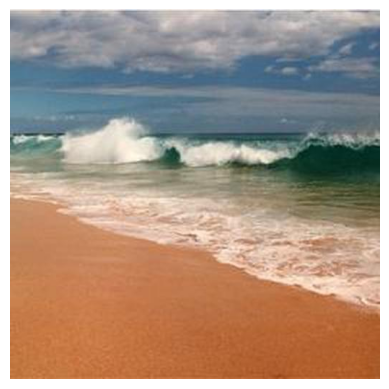

Correct label: seashore

LIME explanation

Prediction seashore


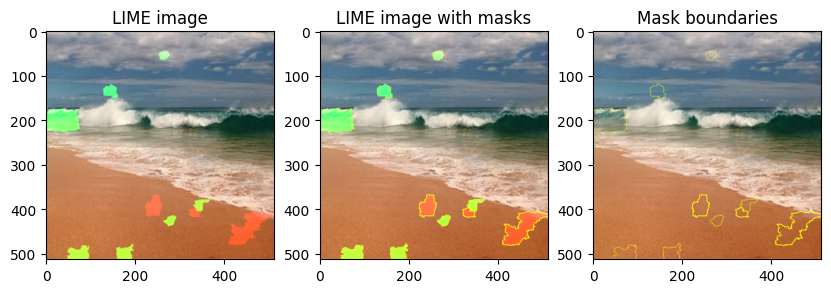

None


In [66]:
# Image 1
print(vizualise_explanation(0))